Epoch [10/100], Loss: 0.0071
Epoch [20/100], Loss: 0.0031
Epoch [30/100], Loss: 0.0003
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000

Test Loss: 0.0000


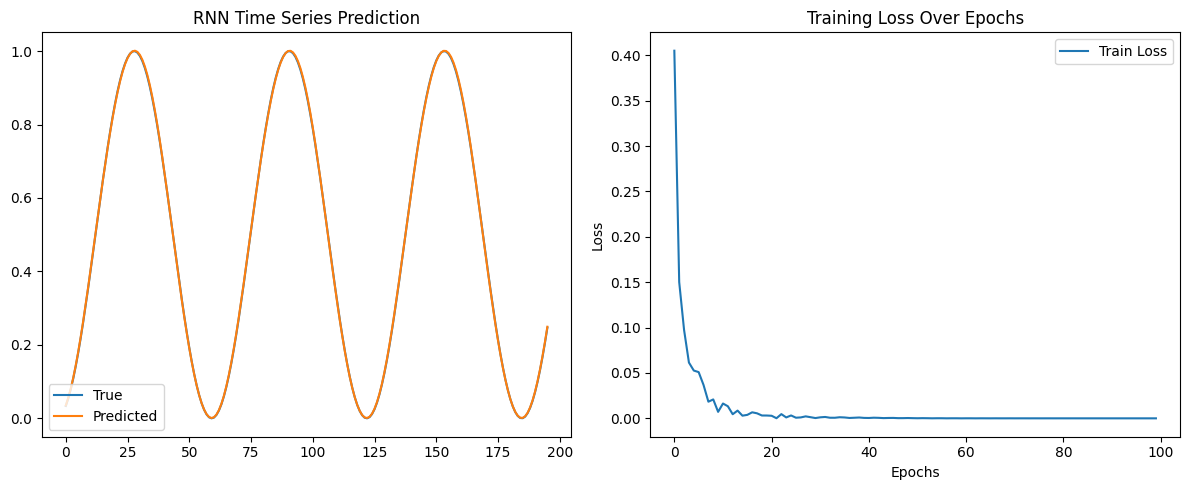

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate sine wave data
def generate_data(seq_length=50):
    x = np.linspace(0, 100, 1000)
    data = np.sin(x)
    return data

# Convert data into sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

# Define RNN model
class RNNPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(RNNPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take output of last time step
        out = self.fc(out)
        return out

# Prepare data
data = generate_data()
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

seq_length = 20
X, y = create_sequences(data, seq_length)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)  # (batch, seq, 1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Model, loss, optimizer
model = RNNPredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "rnn_model.pth")

# Evaluate on test set
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.4f}")

# Plot true vs predicted values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.cpu().numpy(), label='True')
plt.plot(predictions.cpu().numpy(), label='Predicted')
plt.legend()
plt.title("RNN Time Series Prediction")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()